<a href="https://colab.research.google.com/github/MathewBiddle/sandbox/blob/main/notebooks/MBON_occurrences_in_OBIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
import gspread
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import sklearn as skl

## For google spreadsheet reading you need to authenticate w/ google
from google.colab import auth
auth.authenticate_user()


from google.auth import default
creds, _ = default()


In [15]:
matt_howard_url = 'https://docs.google.com/spreadsheets/d/15BSlB2ThK0P6r4QwevdkyiH9812NLqQNayOu0V44Lpc/edit#gid=0'

gc = gspread.authorize(creds)
worksheet = gc.open_by_url(matt_howard_url)
responses = worksheet.worksheet('Sheet1')

df = pd.DataFrame(responses.get_all_records())

for dataset in df.loc[df['OBIS URL'] != '', 'OBIS URL']:
  print(dataset.split("/")[-1])

c9aaa0e9-8f6c-4553-a014-a857baba0680
2ae2a2bd-8412-405b-8a9f-b71adc41d4c5
a54a77db-7b42-4101-8d71-1adec3dd4ed5
36693923-2abf-4237-8154-8016f32844a0
731e318c-d692-4d6b-b4cc-edff0d385098
230e0287-79c3-47f0-9aed-718b63c0a074
1d2c2827-214c-4906-a17b-85941b801228
52f99f08-fc90-4684-aea8-a015150968ea
fbf4cb59-cef3-43be-b0ab-0dbab5f51740
438b8f02-3421-4b2c-a5b2-5934ab76f47b
62125eda-53d3-41bd-ae1f-1b7e0cda2963


In [ ]:
mbon_reg_url = 'https://docs.google.com/spreadsheets/d/1jBS8ASS27yV8APZ8Fh-tgX6dHdopwianrUZv0kbKcxw/edit#gid=1284796732'

gc = gspread.authorize(creds)
worksheet = gc.open_by_url(mbon_reg_url)
responses = worksheet.worksheet('Form Responses 1')

df = pd.DataFrame(responses.get_all_records())

In [ ]:
for dataset in df.loc[df['Has the dataset been submitted to OBIS?']=='Yes','If yes to above, please include appropriate OBIS link(s) here.']:
  print(dataset.split("/")[-1])

d32266b4-d98d-4eed-8207-57dff1f14cc4
ab06f0c6-3de3-447a-b339-a8517f2c95ed
cfceb150-bbe2-4efb-8682-14cfc7167e7c
afef5da2-614b-4208-aee6-c2413ed5ab76
62b97724-da17-4ca7-9b26-b2a22aeaab51
fbf4cb59-cef3-43be-b0ab-0dbab5f51740


In [ ]:
import json
from urllib.request import urlopen
import urllib.parse

base = 'https://api.obis.org/v3/occurrence'

cumulative_size = 0

for dataset in df.loc[df['Has the dataset been submitted to OBIS?']=='Yes','If yes to above, please include appropriate OBIS link(s) here.']:

  datasetid = dataset.split("/")[-1]
  url = '{}?datasetid={}'.format(base,datasetid)

#url = https://api.obis.org/v3/occurrence?datasetid=ab06f0c6-3de3-447a-b339-a8517f2c95ed

  response= urlopen(url)

  data_json = json.loads(response.read())

  data = pd.DataFrame(data_json['results'])

  size = data_json['total']

  cumulative_size = cumulative_size + size

  #combined = pd.concat([combined, data],ignore_index=True)

  print("Found %i records." % size)
  print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?datasetid=',datasetid))

print("\nFound %i total occurrences." % cumulative_size )

Found 4511 records.
See in mapper at: https://mapper.obis.org/?datasetid=d32266b4-d98d-4eed-8207-57dff1f14cc4#
Found 4840 records.
See in mapper at: https://mapper.obis.org/?datasetid=ab06f0c6-3de3-447a-b339-a8517f2c95ed#
Found 237709 records.
See in mapper at: https://mapper.obis.org/?datasetid=cfceb150-bbe2-4efb-8682-14cfc7167e7c#
Found 1320 records.
See in mapper at: https://mapper.obis.org/?datasetid=afef5da2-614b-4208-aee6-c2413ed5ab76#
Found 64841 records.
See in mapper at: https://mapper.obis.org/?datasetid=62b97724-da17-4ca7-9b26-b2a22aeaab51#
Found 53306 records.
See in mapper at: https://mapper.obis.org/?datasetid=fbf4cb59-cef3-43be-b0ab-0dbab5f51740#

Found 366527 total occurrences.


In [ ]:
4511 + 4840 + 237709 + 1320 + 64841 + 53306

366527

In [ ]:
try:
  import geopandas
except:
  !pip install geopandas

In [ ]:
import geopandas as gpd

base = 'https://api.obis.org/v3/'

combined_data = gpd.GeoDataFrame()

location_data = gpd.GeoDataFrame() # initialize df

# build a list of the subset of fields you want back
fields = ['dataset_id','datasetID','id','decimalLatitude','decimalLongitude','species','aphiaID','date_year']
#fields = ['dataset_id','id']

f = "%2C".join([f"{v}" for v in fields])

datasets = df.loc[df['Has the dataset been submitted to OBIS?']=='Yes','If yes to above, please include appropriate OBIS link(s) here.']

for dataset in datasets:

  gpddf = gpd.GeoDataFrame()

  datasetid = dataset.split("/")[-1] # grab the dataset uuid

  print("Dataset ID:",datasetid)

  url = 'https://api.obis.org/v3/occurrence?datasetid={}'.format(datasetid) # build the API url

  print(url)

  # find out how many occurrences we expect
  response = urlopen(url)
  data_json = json.loads(response.read())
  size = data_json['total']

  print("Found %i records." % size)

  # grab the locations
  url = base + 'occurrence/points?datasetid={}'.format(datasetid)
  response = urlopen(url)
  gpddf = gpd.read_file(url)
  gpddf['dataset_id'] = datasetid

  location_data = pd.concat([location_data, gpddf])

print('Final shape:',location_data.shape)

Dataset ID: d32266b4-d98d-4eed-8207-57dff1f14cc4
https://api.obis.org/v3/occurrence?datasetid=d32266b4-d98d-4eed-8207-57dff1f14cc4
Found 4511 records.
Dataset ID: ab06f0c6-3de3-447a-b339-a8517f2c95ed
https://api.obis.org/v3/occurrence?datasetid=ab06f0c6-3de3-447a-b339-a8517f2c95ed
Found 4840 records.
Dataset ID: cfceb150-bbe2-4efb-8682-14cfc7167e7c
https://api.obis.org/v3/occurrence?datasetid=cfceb150-bbe2-4efb-8682-14cfc7167e7c
Found 237709 records.
Dataset ID: afef5da2-614b-4208-aee6-c2413ed5ab76
https://api.obis.org/v3/occurrence?datasetid=afef5da2-614b-4208-aee6-c2413ed5ab76
Found 1320 records.
Dataset ID: 62b97724-da17-4ca7-9b26-b2a22aeaab51
https://api.obis.org/v3/occurrence?datasetid=62b97724-da17-4ca7-9b26-b2a22aeaab51
Found 64841 records.
Dataset ID: fbf4cb59-cef3-43be-b0ab-0dbab5f51740
https://api.obis.org/v3/occurrence?datasetid=fbf4cb59-cef3-43be-b0ab-0dbab5f51740
Found 53306 records.
Final shape: (6, 2)


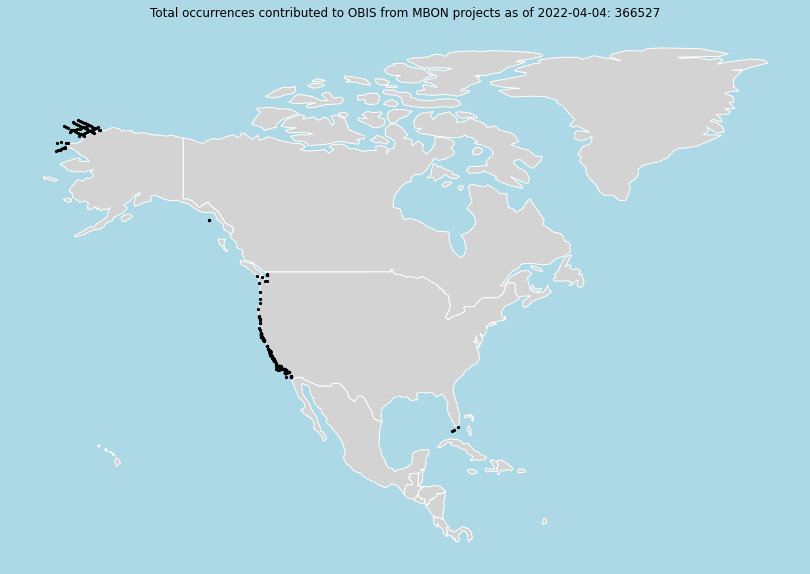

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime


fig, ax = plt.subplots(figsize=(20,10), facecolor='lightblue')

location_data = location_data.to_crs("epsg:4326")
location_data.plot(ax=ax, markersize=5, color='black', zorder=10)

world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

world = world.to_crs(location_data.crs)

world.loc[world['continent'] == 'North America'].plot(ax=ax, color='lightgrey', edgecolor='white', zorder=1)

now = datetime.now()

today = now.strftime("%Y-%m-%d")

plt.title("Total occurrences contributed to OBIS from MBON projects as of %s: %i" % (today, cumulative_size ))

ax.set_axis_off();

plt.show()

NameError: ignored